In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
from matplotlib.offsetbox import AnchoredText
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR

from scipy.stats import pearsonr
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


In [30]:
df = pd.read_csv(r'data\imputed_ML_df.csv', sep='\t')
df = df.drop(['gene_biotype'], axis = 1)
df.set_index('ensembl_gene_id', inplace=True)
df.dropna(inplace=True)
X = df.drop('log_ae', axis = 1)
# X = X.drop('log_eqtl', axis=1)
features = list(X.columns)
y = df['log_ae']
print(df.columns)

Index(['ncRVIS', 'loeuf_score', 'ncGERP', 'RVIS_score', 'ncCADD', 'pHaplo',
       'pTriplo', 'Episcore', 'pLI', 'median_tpm', 'num_enh', 'num_super_enh',
       'tau', 'log_ae', 'log_eqtl'],
      dtype='object')


In [31]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.25, random_state = 42)
print('Training Features Shape:', train_X.shape)
print('Training Labels Shape:', train_y.shape)
print('Testing Features Shape:', test_X.shape)
print('Testing Labels Shape:', test_y.shape)
print(sum([train_X.shape[0], test_X.shape[0]])==len(df), len(df))


Training Features Shape: (9003, 14)
Training Labels Shape: (9003,)
Testing Features Shape: (3001, 14)
Testing Labels Shape: (3001,)
True 12004


## Note
The parameter learning_rate strongly interacts with the parameter n_estimators, the number of weak learners to fit. Smaller values of learning_rate require larger numbers of weak learners to maintain a constant training error. Empirical evidence suggests that small values of learning_rate favor better test error. [HTF] recommend to set the learning rate to a small constant (e.g. learning_rate <= 0.1) and choose n_estimators by early stopping. For a more detailed discussion of the interaction between learning_rate and n_estimators see [R2007].
https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting-loss

# XGBoost

## function XGBoost

In [32]:
def XG(X_train, y_train, grid_search = False, specified_params = False, params=dict(), n_cores=4, n_iter = 2000):

   
    steps = [('scaler', StandardScaler()),('regr',xgb.XGBRegressor(seed=20, verbosity = 1))]
    pipe = Pipeline(steps)

    xgb_params = {
        'regr__max_depth': [3, 5, 6, 10, 15, 20,30],
        'regr__learning_rate': [0.001, 0.01, 0.1, 0.2], # aka eta or epsilon
        'regr__subsample': np.arange(0.5, 1.0, 0.1),
        'regr__colsample_bytree': np.arange(0.4, 1.0, 0.1),
        'regr__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
        'regr__n_estimators': [100, 500, 1000],
        'regr__min_split_loss' : [0, 1, 2, 5],
        'regr__reg_lambda' : [1, 2, 5], # gamma
        'regr__reg_alpha' : [0, 1 , 2, 5]
        }
        # lambda ==> L2 regularization parameter ==> prevent overfitting (default = 1)
        # alpha ==> L1 regularization parameter (default = 0)
        # gamma ==> aka min_split_loss ==> important for pruning  (default = 0)
        # for all of the three parameters: ==> the larger the more conservative and range[0, inf]           
    if grid_search:
        search = GridSearchCV(
            pipe,
            param_grid = xgb_params,
            scoring = 'neg_root_mean_squared_error',
            n_jobs=n_cores,
            verbose=1
            )
    elif specified_params:
        xgb_params = params
        search = GridSearchCV(
            pipe,
            param_grid = xgb_params,
            n_jobs=n_cores,
            scoring = 'neg_root_mean_squared_error',
            verbose=1
            )
    else:
        search =  RandomizedSearchCV(
            pipe,
            n_iter = n_iter,
            param_distributions= xgb_params,
            scoring='neg_root_mean_squared_error',
            random_state=42,
            n_jobs=n_cores,
            verbose = 1,
            cv = 3
            )
    
    search.fit(X_train, y_train)
    return search

## initial XGBoost model

In [33]:

initial_params = {'regr__subsample': [0.6], 'regr__n_estimators': [700], 'regr__max_depth': [3], 'regr__learning_rate': [0.01], 'regr__colsample_bytree': [0.6], 'regr__colsample_bylevel': [0.6]}

search = XG(train_X, train_y, specified_params = True, params=initial_params)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


## Fig. 5A

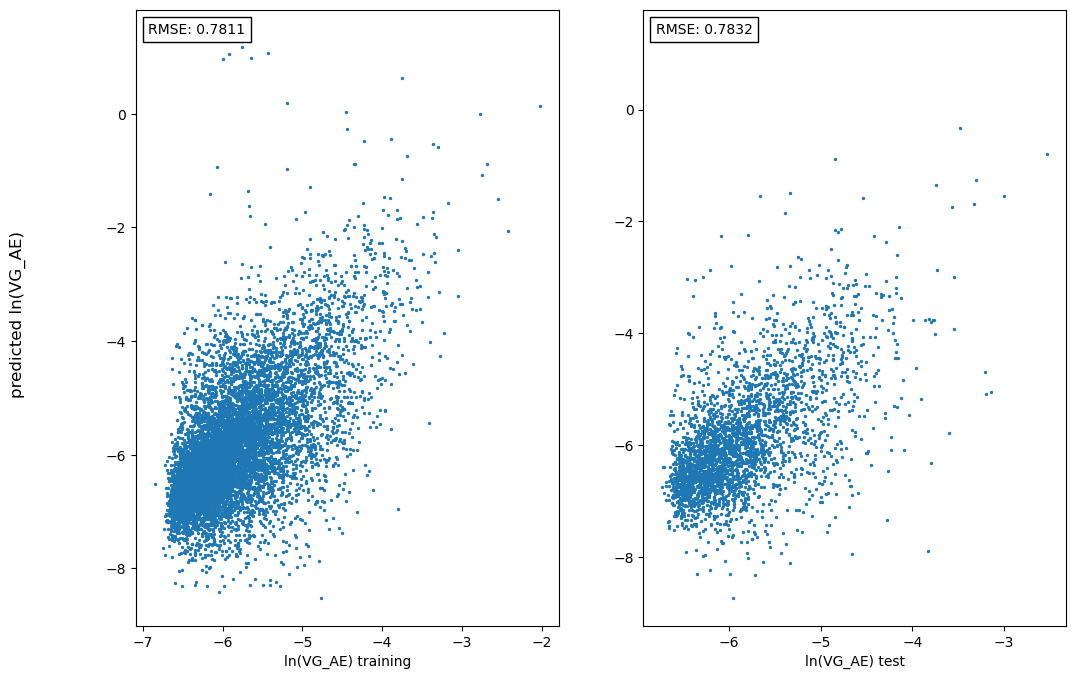

[[1.         0.63727612]
 [0.63727612 1.        ]] [[1.         0.58893712]
 [0.58893712 1.        ]]
1.0e-279 0.0
1.0e-279 0.0 0.5889371189700672 0.6372761188735575


In [34]:
train_pred = search.predict(train_X)
test_pred = search.predict(test_X)
fig, axs = plt.subplots(1, 2, figsize = (12,8))
#s_rho, s_p = spearmanr(test_pred, test_y)

p_rho_train, p_p_train = pearsonr(train_pred, train_y)
pearson_train = 'pearson corr: '+str(round(p_rho_train,3)) #+'\n'+'p value: ' +str(p_p_train)
rmse_train = 'RMSE: '+str(round(np.sqrt(mean_absolute_error(train_y, train_pred)), 4))

p_rho_test, p_p_test = pearsonr(test_pred, test_y)
p_p_test = str(p_p_test)[0:3]+str(p_p_test)[-5:]
pearson_test = 'pearson corr: '+str(round(p_rho_test, 3)) #+'\n' +'p value: '+str(p_p_test)
rmse_test = 'RMSE: '+str(round(np.sqrt(mean_absolute_error(test_y, test_pred)),4))

axs[0].scatter(train_pred, train_y, s = 2)
axs[0].add_artist(AnchoredText(rmse_train, loc=2))
axs[0].set_xlabel('ln(VG_AE) training')

axs[1].scatter(test_pred, test_y, s = 2)
axs[1].add_artist(AnchoredText(rmse_test, loc=2))
axs[1].set_xlabel('ln(VG_AE) test')

fig.supylabel('predicted ln(VG_AE)')
plt.show()
# fig.savefig(r'datacollection\images\final_report\xgb_initial.png', dpi = 300,bbox_inches='tight')

# fig.savefig(r'datacollection\images\final_report\xgb_initial.svg', dpi = 96,bbox_inches='tight')

print(np.corrcoef(train_pred, train_y), np.corrcoef(test_pred, test_y))
print(p_p_test, p_p_train)
print(p_p_test, p_p_train,p_rho_test ,p_rho_train)

## optimized XGBoost model


In [35]:
def extract_params(search_df_path, sep = '\t'):
    search_df = pd.read_csv(search_df_path, sep = sep)
    params =  search_df.loc[search_df['rank_test_score']==1,'params'].values[0]
    params = eval(str(params))
    for key, value in params.items():
        params[key] = [value]
    return params


In [36]:
path = r'data\xgb_randomsearch_20k_iter.csv'
best_params = extract_params(path)
print(best_params)
search = XG(train_X, train_y, specified_params = True, params=best_params)


{'regr__subsample': [0.6], 'regr__reg_lambda': [5], 'regr__reg_alpha': [2], 'regr__n_estimators': [1000], 'regr__min_split_loss': [2], 'regr__max_depth': [5], 'regr__learning_rate': [0.01], 'regr__colsample_bytree': [0.8999999999999999], 'regr__colsample_bylevel': [0.5]}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


## Fig. 5B

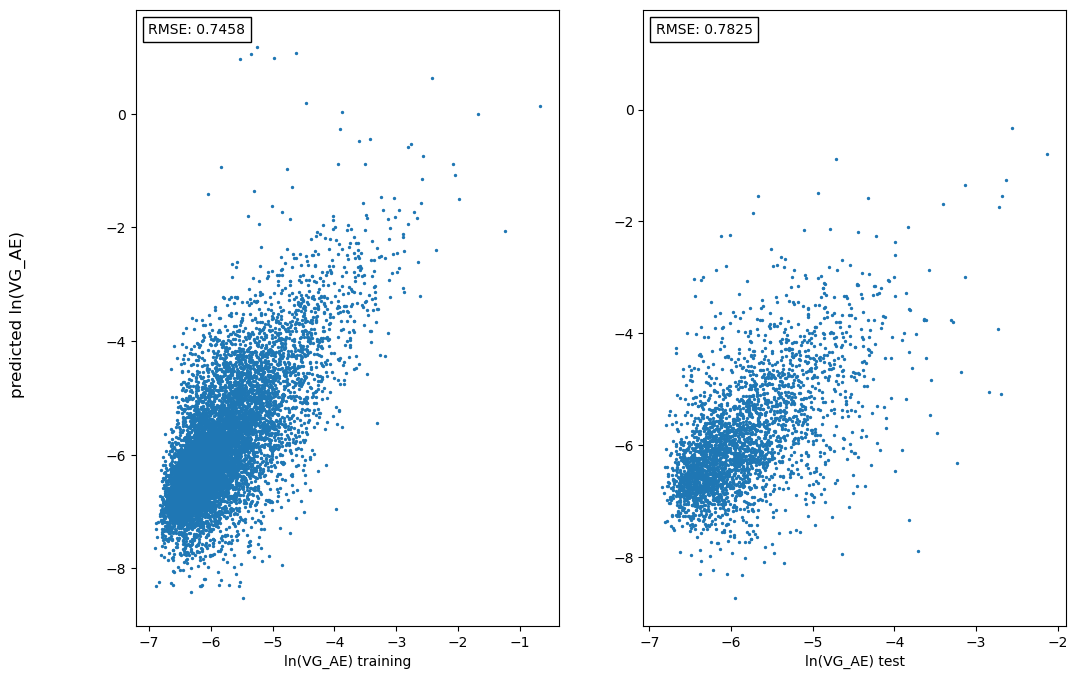

[[1.        0.7169499]
 [0.7169499 1.       ]] [[1.         0.58863303]
 [0.58863303 1.        ]]
2.3e-279 0.0
2.3e-279 0.0 0.5886330273940205 0.7169499030895784


In [37]:
train_pred = search.predict(train_X)
test_pred = search.predict(test_X)
fig, axs = plt.subplots(1, 2, figsize = (12,8))
#s_rho, s_p = spearmanr(test_pred, test_y)

p_rho_train, p_p_train = pearsonr(train_pred, train_y)
pearson_train = 'pearson corr: '+str(round(p_rho_train,3))
rmse_train = 'RMSE: '+str(round(np.sqrt(mean_absolute_error(train_y, train_pred)), 4))

p_rho_test, p_p_test = pearsonr(test_pred, test_y)
p_p_test = str(p_p_test)[0:3]+str(p_p_test)[-5:]
pearson_test = 'pearson corr: '+str(round(p_rho_test, 3)) 
rmse_test = 'RMSE: '+str(round(np.sqrt(mean_absolute_error(test_y, test_pred)),4))

axs[0].scatter(train_pred, train_y, s = 2)
axs[0].add_artist(AnchoredText(rmse_train, loc=2))
axs[0].set_xlabel('ln(VG_AE) training')

axs[1].scatter(test_pred, test_y, s = 2)
axs[1].add_artist(AnchoredText(rmse_test, loc=2))
axs[1].set_xlabel('ln(VG_AE) test')

fig.supylabel('predicted ln(VG_AE)')
plt.show()
# fig.savefig(r'datacollection\images\final_report\gb_initial.png', dpi = 300,bbox_inches='tight')

# fig.savefig(r'datacollection\images\final_report\xgb_refined.svg', dpi = 96,bbox_inches='tight')

print(np.corrcoef(train_pred, train_y), np.corrcoef(test_pred, test_y))
print(p_p_test, p_p_train)
print(p_p_test, p_p_train,p_rho_test ,p_rho_train)

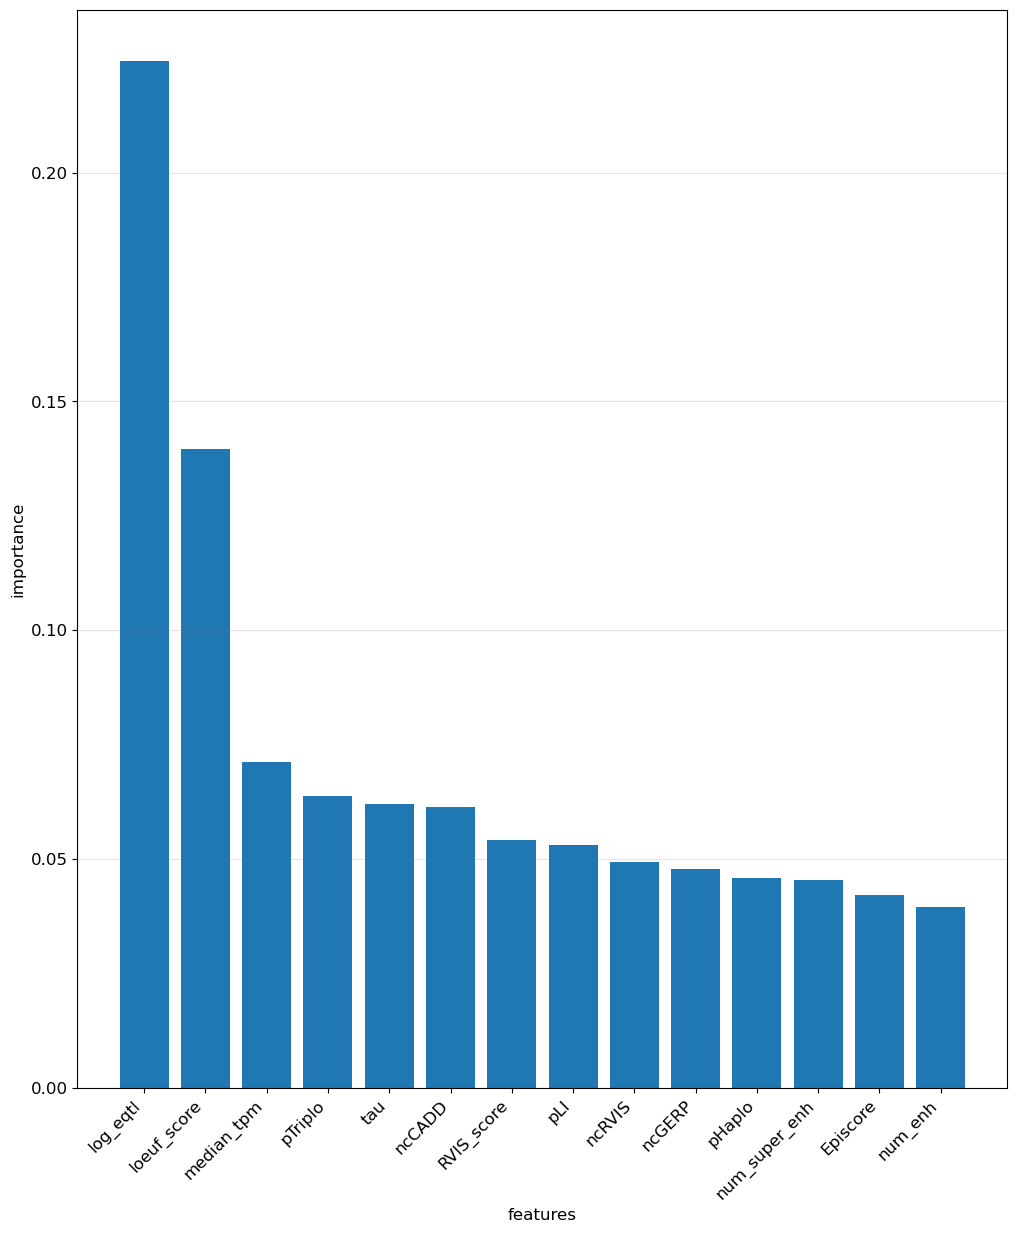

In [38]:
importances = list(search.best_estimator_[1].feature_importances_)
imp_df = pd.DataFrame({'features': features,'importance' : importances})
imp_df.sort_values(by='importance',axis=0, ascending=False, inplace= True)
plt.figure(figsize=(12,14))
plt.bar(imp_df['features'], imp_df['importance'])
plt.xlabel('features', fontsize=12)
plt.ylabel('importance', fontsize=12)
plt.xticks(rotation=45, fontsize = 12, ha='right')
plt.yticks( fontsize = 12)
plt.grid(axis='y', color='grey', alpha=0.2)



# plt.savefig(r'datacollection\images\final_report\xgb_feature_importance.png')

plt.savefig(r'datacollection\images\final_report\suppl\xgb_feature_importance.svg', dpi=96, bbox_inches='tight')
plt.show()

# gradient boosting

## function gradient boosting

In [39]:
def GB(X_train, y_train, grid_search = False, specified_params = False, params = dict(), n_cores=4):

   
    steps = [('scaler', StandardScaler()),('regr',GradientBoostingRegressor())]
    pipe = Pipeline(steps)

    pipeline_params =  {
        'regr__loss' : ['squared_error'],
        'regr__max_depth': [3, 5, 6, 10, 15, 20],
        'regr__learning_rate': [0.01, 0.1, 0.2, 0.3],
        'regr__subsample': np.arange(0.5, 1.0, 0.1),
        'regr__min_samples_split': np.arange(0.3, 1.0, 0.1),
        'regr__min_samples_leaf':np.arange(0.3, 1.0, 0.1),
        'regr__max_features':np.arange(0.3, 1.0, 0.2),
        'regr__n_estimators': [100, 500, 1000]    
        }
    
    if grid_search:
        search = GridSearchCV(
            pipe,
            param_grid = pipeline_params,
            scoring = 'neg_root_mean_squared_error',
            n_jobs=n_cores,
            verbose=1
            )
    elif specified_params:
        pipeline_params = params
        search = GridSearchCV(
            pipe,
            param_grid = pipeline_params,
            n_jobs=n_cores,
            scoring = 'neg_root_mean_squared_error',
            verbose=1
            )
    else:
        search =  RandomizedSearchCV(
            pipe,
            n_iter = 25,
            param_distributions= pipeline_params,
            scoring='neg_root_mean_squared_error',
            random_state=42,
            n_jobs=n_cores,
            verbose = 1
            )
    
    search.fit(X_train, y_train)
    return search



## initial GB model

In [40]:
initial_params = pipeline_params={
    'regr__learning_rate': [0.01],
    'regr__loss': ['squared_error'],
    'regr__min_samples_split': [8],
    'regr__n_estimators': [500],
    'regr__subsample': [0.5] 
}
search = GB(train_X, train_y, specified_params = True, params=initial_params)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


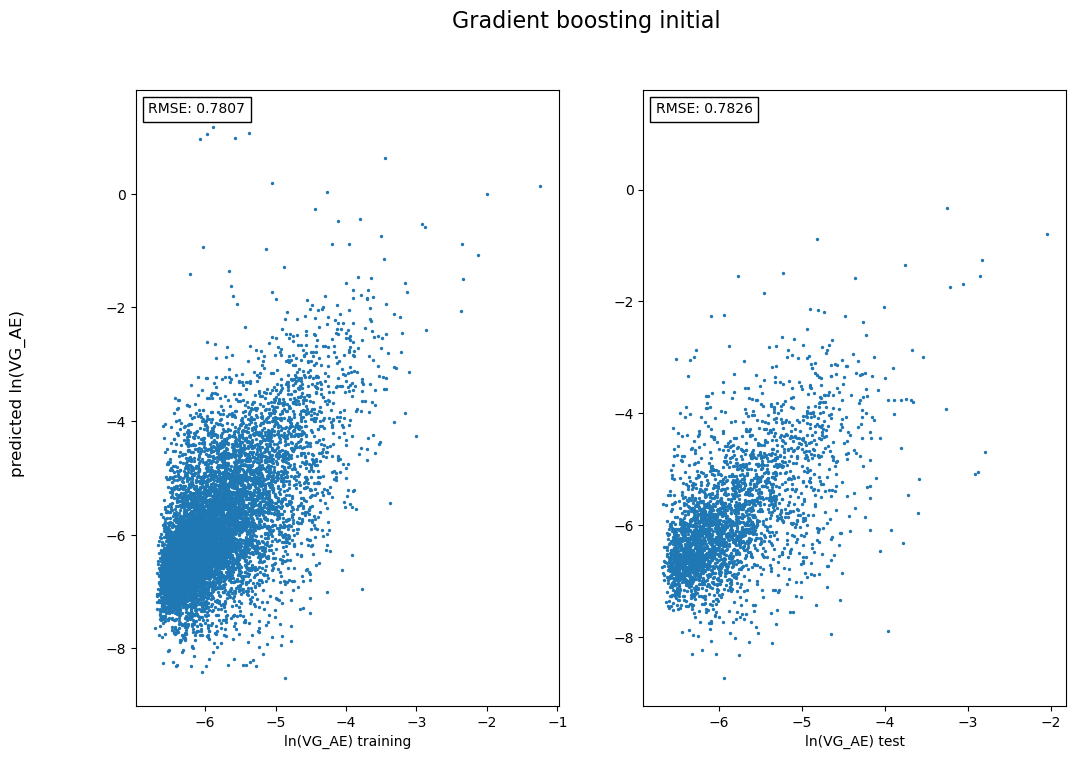

[[1.         0.63744035]
 [0.63744035 1.        ]] [[1.         0.59249692]
 [0.59249692 1.        ]]
6.2e-284 0.0
6.2e-284 0.0 0.5924969184464801 0.6374403451552954


In [41]:
train_pred = search.predict(train_X)
test_pred = search.predict(test_X)
fig, axs = plt.subplots(1, 2, figsize = (12,8))
#s_rho, s_p = spearmanr(test_pred, test_y)

p_rho_train, p_p_train = pearsonr(train_pred, train_y)
pearson_train = 'pearson corr: '+str(round(p_rho_train,3))
rmse_train = 'RMSE: '+str(round(np.sqrt(mean_absolute_error(train_y, train_pred)), 4))

p_rho_test, p_p_test = pearsonr(test_pred, test_y)
p_p_test = str(p_p_test)[0:3]+str(p_p_test)[-5:]
pearson_test = 'pearson corr: '+str(round(p_rho_test, 3)) 
rmse_test = 'RMSE: '+str(round(np.sqrt(mean_absolute_error(test_y, test_pred)),4))

axs[0].scatter(train_pred, train_y, s = 2)
axs[0].add_artist(AnchoredText(rmse_train, loc=2))
axs[0].set_xlabel('ln(VG_AE) training')

axs[1].scatter(test_pred, test_y, s = 2)
axs[1].add_artist(AnchoredText(rmse_test, loc=2))
axs[1].set_xlabel('ln(VG_AE) test')

fig.supylabel('predicted ln(VG_AE)')
fig.suptitle('Gradient boosting initial', fontsize =16)
plt.show()
# fig.savefig(r'datacollection\images\final_report\gb_initial.png', dpi = 300,bbox_inches='tight')

fig.savefig(r'datacollection\images\final_report\suppl\gb_initial.svg', dpi = 96,bbox_inches='tight')

print(np.corrcoef(train_pred, train_y), np.corrcoef(test_pred, test_y))
print(p_p_test, p_p_train)
print(p_p_test, p_p_train,p_rho_test ,p_rho_train)

## refined model

In [42]:
path = r'data\gb_randsearch_grid.csv'
best_params = extract_params(path)
print(best_params)
search = GB(train_X, train_y, specified_params = True, params=best_params)


{'regr__learning_rate': [0.2], 'regr__loss': ['squared_error'], 'regr__max_depth': [3], 'regr__max_features': [0.7000000000000002], 'regr__min_samples_leaf': [0.3], 'regr__min_samples_split': [0.5], 'regr__n_estimators': [100], 'regr__subsample': [0.8999999999999999]}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


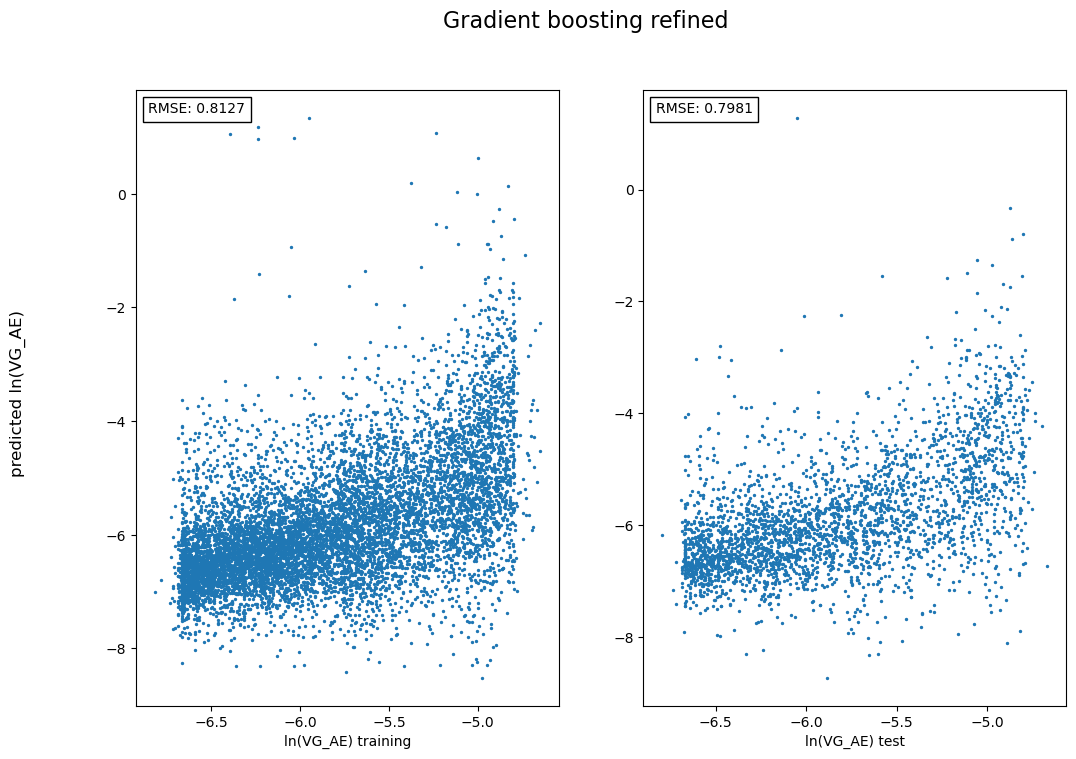

[[1.         0.53315305]
 [0.53315305 1.        ]] [[1.         0.54109698]
 [0.54109698 1.        ]]
6.7e-228 0.0
6.7e-228 0.0 0.5410969763777758 0.5331530491390023


In [43]:
train_pred = search.predict(train_X)
test_pred = search.predict(test_X)
fig, axs = plt.subplots(1, 2, figsize = (12,8))
#s_rho, s_p = spearmanr(test_pred, test_y)

p_rho_train, p_p_train = pearsonr(train_pred, train_y)
pearson_train = 'pearson corr: '+str(round(p_rho_train,3))
rmse_train = 'RMSE: '+str(round(np.sqrt(mean_absolute_error(train_y, train_pred)), 4))

p_rho_test, p_p_test = pearsonr(test_pred, test_y)
p_p_test = str(p_p_test)[0:3]+str(p_p_test)[-5:]
pearson_test = 'pearson corr: '+str(round(p_rho_test, 3)) 
rmse_test = 'RMSE: '+str(round(np.sqrt(mean_absolute_error(test_y, test_pred)),4))

axs[0].scatter(train_pred, train_y, s = 2)
axs[0].add_artist(AnchoredText(rmse_train, loc=2))
axs[0].set_xlabel('ln(VG_AE) training')

axs[1].scatter(test_pred, test_y, s = 2)
axs[1].add_artist(AnchoredText(rmse_test, loc=2))
axs[1].set_xlabel('ln(VG_AE) test')

fig.supylabel('predicted ln(VG_AE)')
fig.suptitle('Gradient boosting refined', fontsize =16)

plt.show()
# fig.savefig(r'datacollection\images\final_report\gb_initial.png', dpi = 300,bbox_inches='tight')

# fig.savefig(r'datacollection\images\final_report\suppl\gb_refined.svg', dpi = 96,bbox_inches='tight')

print(np.corrcoef(train_pred, train_y), np.corrcoef(test_pred, test_y))
print(p_p_test, p_p_train)
print(p_p_test, p_p_train,p_rho_test ,p_rho_train)

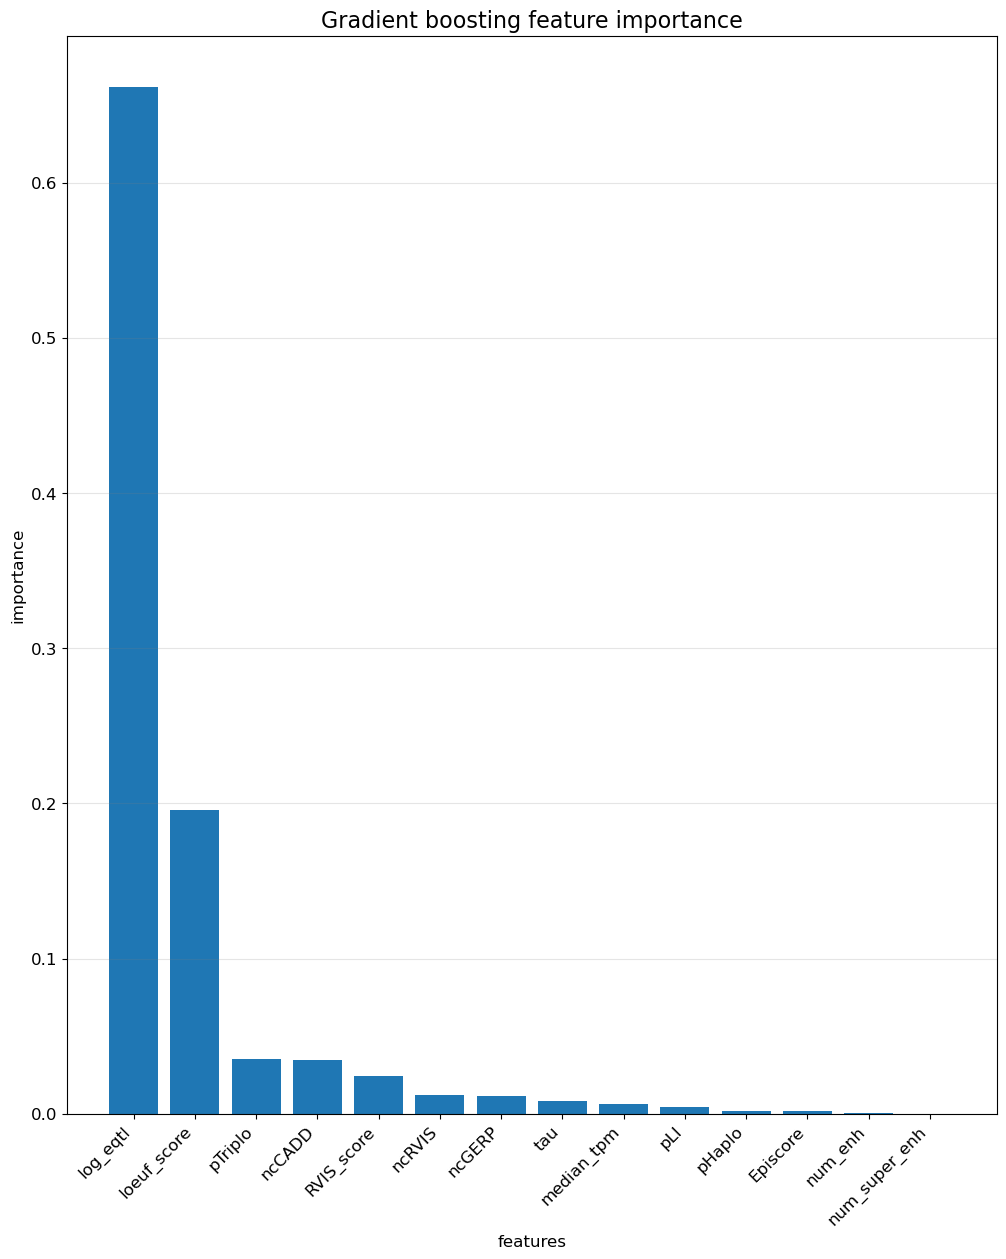

In [44]:
importances = list(search.best_estimator_[1].feature_importances_)
imp_df = pd.DataFrame({'features': features,'importance' : importances})
imp_df.sort_values(by='importance',axis=0, ascending=False, inplace= True)
plt.figure(figsize=(12,14))
plt.bar(imp_df['features'], imp_df['importance'])
plt.xlabel('features', fontsize=12)
plt.ylabel('importance', fontsize=12)
plt.xticks(rotation=45, fontsize = 12, ha='right')
plt.yticks( fontsize = 12)
plt.grid(axis='y', color='grey', alpha=0.2)
plt.title('Gradient boosting feature importance', fontsize =16)


# plt.savefig(r'datacollection\images\final_report\xgb_feature_importance.png')

# plt.savefig(r'datacollection\images\final_report\suppl\gb_feature_importance.svg', dpi=96, bbox_inches='tight')
plt.show()

# Support vector regressor

## SVR function

In [45]:
def SV(X_train, y_train, grid_search = False, specified_params = False, params = dict(), n_cores=4):

    steps = [('scaler', StandardScaler()),('regr',SVR())]
    pipe = Pipeline(steps)

    pipeline_params = {
        'svm__C': 1*10**np.arange(0, 5.0),
        'svm__gamma':np.arange(0.0005,0.5,0.05),
        'svm__epsilon': 1*10**np.arange(-4, 4.0) ,
        'svm__kernel': ['rbf'] #linear and poly are more options
    }
    
    if grid_search:
        search = GridSearchCV(
            pipe,
            param_grid = pipeline_params,
            scoring = 'neg_root_mean_squared_error',
            n_jobs=n_cores,
            verbose=1
            )
    elif specified_params:
        pipeline_params = params
        search = GridSearchCV(
            pipe,
            param_grid = pipeline_params,
            n_jobs=n_cores,
            scoring = 'neg_root_mean_squared_error',
            verbose=1
            )
    else:
        search =  RandomizedSearchCV(
            pipe,
            n_iter = 25,
            param_distributions= pipeline_params,
            scoring='neg_root_mean_squared_error',
            random_state=42,
            n_jobs=n_cores,
            verbose = 1
            )
    
    search.fit(X_train, y_train)
    return search



## initial SVR model

In [46]:
initial_params =  {'regr__kernel': ['rbf'],
 'regr__gamma': [0.0005],
 'regr__epsilon': [1.0],
 'regr__C': [1000.0]}
search = SV(train_X, train_y, specified_params = True, params=initial_params)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


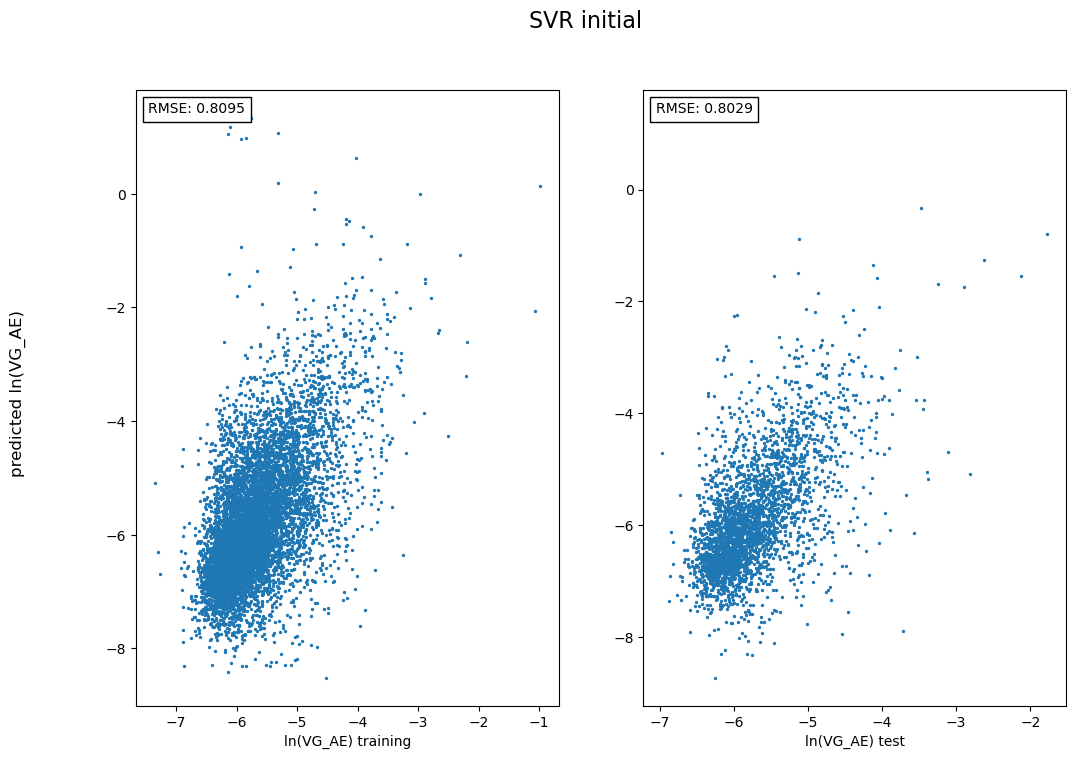

[[1.         0.59830272]
 [0.59830272 1.        ]] [[1.         0.57947266]
 [0.57947266 1.        ]]
8.8e-269 0.0
8.8e-269 0.0 0.5794726617053996 0.5983027181607224


In [47]:
train_pred = search.predict(train_X)
test_pred = search.predict(test_X)
fig, axs = plt.subplots(1, 2, figsize = (12,8))
#s_rho, s_p = spearmanr(test_pred, test_y)

p_rho_train, p_p_train = pearsonr(train_pred, train_y)
pearson_train = 'pearson corr: '+str(round(p_rho_train,3))
rmse_train = 'RMSE: '+str(round(np.sqrt(mean_absolute_error(train_y, train_pred)), 4))

p_rho_test, p_p_test = pearsonr(test_pred, test_y)
p_p_test = str(p_p_test)[0:3]+str(p_p_test)[-5:]
pearson_test = 'pearson corr: '+str(round(p_rho_test, 3)) 
rmse_test = 'RMSE: '+str(round(np.sqrt(mean_absolute_error(test_y, test_pred)),4))

axs[0].scatter(train_pred, train_y, s = 2)
axs[0].add_artist(AnchoredText(rmse_train, loc=2))
axs[0].set_xlabel('ln(VG_AE) training')

axs[1].scatter(test_pred, test_y, s = 2)
axs[1].add_artist(AnchoredText(rmse_test, loc=2))
axs[1].set_xlabel('ln(VG_AE) test')

fig.supylabel('predicted ln(VG_AE)')
fig.suptitle('SVR initial', fontsize =16)

plt.show()
# fig.savefig(r'datacollection\images\final_report\gb_initial.png', dpi = 300,bbox_inches='tight')

# fig.savefig(r'datacollection\images\final_report\suppl\svr_initial.svg', dpi = 96,bbox_inches='tight')

print(np.corrcoef(train_pred, train_y), np.corrcoef(test_pred, test_y))
print(p_p_test, p_p_train)
print(p_p_test, p_p_train,p_rho_test ,p_rho_train)

## refined SVR model

In [48]:
path = r'data\svm_gridsearch_uppm.csv'
test_df = pd.read_csv(path, sep='\t')
test_df = test_df.replace({'svm__':'regr__'}, regex=True)
cols = list(test_df.columns)
for ind, col in enumerate(cols):
    if 'svm__' in str(col):

        new_col = str(col).replace('svm__','regr__')
        cols[ind] = new_col
test_df.columns = cols
test_df.to_csv(r'data\svm_gridsearch_uppm_formatted.csv', sep='\t')

In [49]:
path = r'data\svm_gridsearch_uppm_formatted.csv'

best_params = extract_params(path)
print(best_params)
search = SV(train_X, train_y, specified_params = True, params=best_params)


{'regr__kernel': ['rbf'], 'regr__gamma': [0.0005], 'regr__epsilon': [0.001], 'regr__C': [1000.0]}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


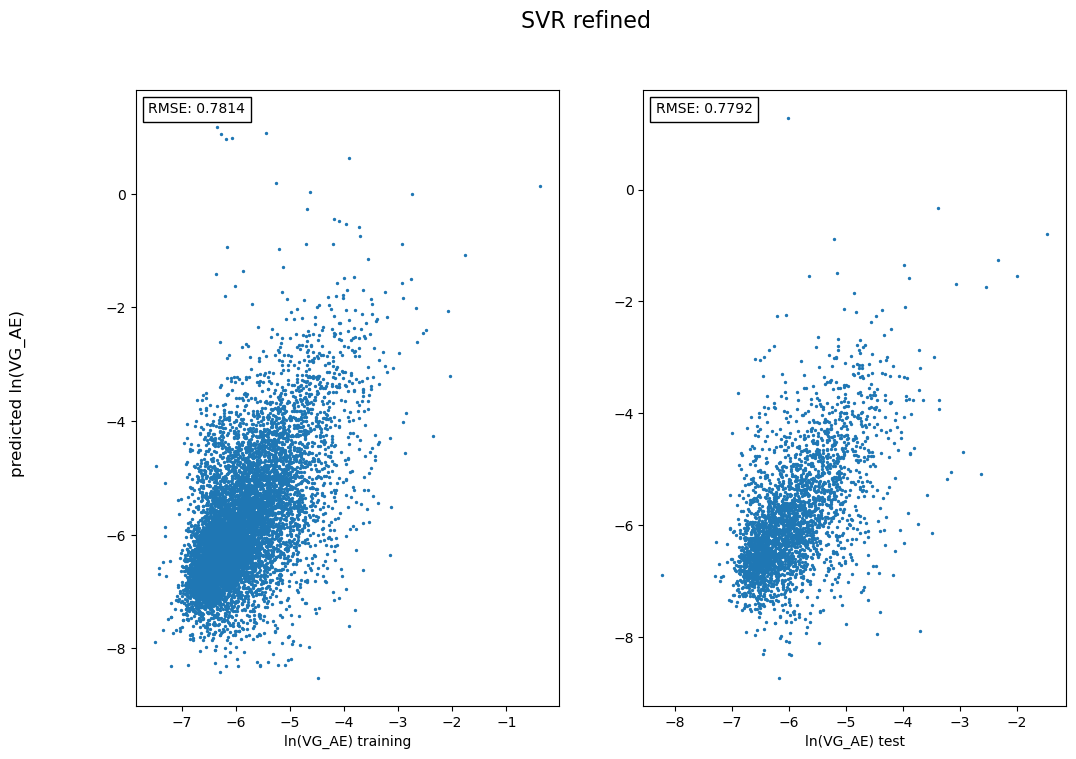

[[1.         0.60363724]
 [0.60363724 1.        ]] [[1.         0.58524476]
 [0.58524476 1.        ]]
2.0e-275 0.0
2.0e-275 0.0 0.5852447579014886 0.6036372445423479


In [50]:

train_pred = search.predict(train_X)
test_pred = search.predict(test_X)
fig, axs = plt.subplots(1, 2, figsize = (12,8))
#s_rho, s_p = spearmanr(test_pred, test_y)

p_rho_train, p_p_train = pearsonr(train_pred, train_y)
pearson_train = 'pearson corr: '+str(round(p_rho_train,3))
rmse_train = 'RMSE: '+str(round(np.sqrt(mean_absolute_error(train_y, train_pred)), 4))

p_rho_test, p_p_test = pearsonr(test_pred, test_y)
p_p_test = str(p_p_test)[0:3]+str(p_p_test)[-5:]
pearson_test = 'pearson corr: '+str(round(p_rho_test, 3)) 
rmse_test = 'RMSE: '+str(round(np.sqrt(mean_absolute_error(test_y, test_pred)),4))

axs[0].scatter(train_pred, train_y, s = 2)
axs[0].add_artist(AnchoredText(rmse_train, loc=2))
axs[0].set_xlabel('ln(VG_AE) training')

axs[1].scatter(test_pred, test_y, s = 2)
axs[1].add_artist(AnchoredText(rmse_test, loc=2))
axs[1].set_xlabel('ln(VG_AE) test')

fig.supylabel('predicted ln(VG_AE)')
fig.suptitle('SVR refined', fontsize =16)

plt.show()
# fig.savefig(r'datacollection\images\final_report\gb_initial.png', dpi = 300,bbox_inches='tight')

# fig.savefig(r'datacollection\images\final_report\suppl\svr_refined.svg', dpi = 96,bbox_inches='tight')

print(np.corrcoef(train_pred, train_y), np.corrcoef(test_pred, test_y))
print(p_p_test, p_p_train)
print(p_p_test, p_p_train,p_rho_test ,p_rho_train)
